<table align="left"><td>
  <a target="_blank"  href="https://github.com/Dhruv0208/Research-Project/Autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/Dhruv0208/Research-Project/Autoencoder.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

In [1]:
# import sys
# !{sys.executable} -m pip install keras
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install imutils
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install -q tfds-nightly tensorflow
# !{sys.executable} -m pip install pydot
# !{sys.executable} -m pip install graphviz
# !{sys.executable} -m pip install pydotplus

In [3]:
import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Input
from tensorflow.python.keras.utils.vis_utils import plot_model
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import json
from functools import partial
import os
from imutils import paths
import cv2
import IPython.display as display
import multiprocessing

In [3]:
print(tf.__version__)

2.3.1


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}',format(device_name))

Found GPU at: {} /device:GPU:0


In [5]:
# splits = ['train', 'validation', 'test']
# (train_dataset, val_dataset, test_dataset), dataset_info = tfds.load(name='coco/2017', data_dir = '../dhruv', 
#                                                        split = list(splits), 
#                                                        download=False, with_info=True,
#                                                                     as_supervised=False)
# assert isinstance(train_dataset, tf.data.Dataset)
# assert isinstance(val_dataset, tf.data.Dataset)
# assert isinstance(test_dataset, tf.data.Dataset)
# print(train_dataset)
# print(val_dataset)
# print(test_dataset)

In [6]:
# file_pattern = f'coco/2017/1.1.0/coco-train.tfrecord*'
# files = tf.data.Dataset.list_files(file_pattern)

In [7]:
# len(files)

In [8]:
# train_ds = files.interleave(tf.data.TFRecordDataset,
#                            cycle_length = 4,
#                            num_parallel_calls = tf.data.experimental.AUTOTUNE)
# # train_ds = tf.data.TFRecordDataset(file_pattern)

In [9]:
# def read_tfrecord(serialized_example):
#     feature_description={
#         "image": tf.io.FixedLenFeature((), tf.string, "")
#     }
#     example = tf.io.parse_single_example(
#     serialized_example, feature_description
#     )
#     image = tf.io.decode_jpeg(example['image'], channels=3)
#     image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#     image = image / 255
#     image = tf.image.resize(image, (512, 512))
#     return image

In [10]:
# cores = multiprocessing.cpu_count()
# print(cores)

# train_ds = train_ds.map(read_tfrecord, num_parallel_calls=cores)
# train_ds = train_ds.cache()

In [11]:
# for inputs in train_ds.take(1):
#     print(inputs)

In [12]:
# train_ds = train_ds.shuffle(1024).batch(1)
# train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [512,512]
BATCH_SIZE = 4

In [36]:
file_pattern_train = f'coco/2017/1.1.0/coco-train.tfrecord*'
file_pattern_test = f'coco/2017/1.1.0/coco-test.tfrecord*'
file_pattern_valid = f'coco/2017/1.1.0/coco-validation.tfrecord*'
Training_filenames = tf.data.Dataset.list_files(file_pattern_train)
Test_filenames = tf.data.Dataset.list_files(file_pattern_test)
Valid_filenames = tf.data.Dataset.list_files(file_pattern_valid)
print("Train Tfrecords Files: ", len(Training_filenames))
print("Test Tfrecords Files: ", len(Test_filenames))
print("Valid Tfrecords Files: ", len(Valid_filenames))

Train Tfrecords Files:  256
Test Tfrecords Files:  64
Valid Tfrecords Files:  8


In [37]:
def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [*IMAGE_SIZE])
    return image

In [38]:
def read_tfrecord(serialized_example):
    feature_description={
        "image": tf.io.FixedLenFeature([], tf.string,)
    }
    example = tf.io.parse_single_example(
    serialized_example, feature_description
    )
    image = decode_image(example['image'])
    return image

In [39]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(
        filenames)
    dataset = dataset.with_options(ignore_order)
    dataset =dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE)
    return dataset

In [40]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(1024)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


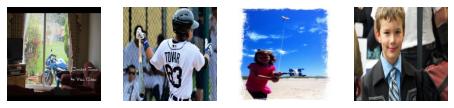

In [41]:
train_dataset = get_dataset(Training_filenames)
valid_dataset = get_dataset(Valid_filenames)
test_dataset = get_dataset(Test_filenames)
# train_dist_datset = strategy.experimental_distribute_dataset(train_dataset)
# test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)
# valid_dist_dataset = strategy.experimental_distribute_dataset(valid_dataset)
image_batch = next(iter(train_dataset))
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(4):
        ax = plt.subplot(5,5, n+1)
        print(image_batch[n].shape)
        plt.imshow(image_batch[n] / 255.0)
        plt.axis("off")
        
show_batch(image_batch.numpy())

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

## Preparing autoencoder

In [16]:
input_img = Input(shape=(512,512,3))
x = layers.Conv2D(256, (1,1), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(256, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)


In [43]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 256)     1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)       

In [23]:
# plot_model(autoencoder, show_shapes=True)

## Extracting Features from intermediate layers

In [24]:
# intermediate_layer_model_1 = keras.Model(inputs=autoencoder.inputs,
#                                       outputs=autoencoder.get_layer('max_pooling2d_1').output)
# features_1 = intermediate_layer_model_1(train_ds)
# intermediate_layer_model_2 = keras.Model(inputs=autoencoder.inputs,
#                                       outputs=autoencoder.get_layer('max_pooling2d_3').output)
# features_2 = intermediate_layer_model_1(train_ds)
# intermediate_layer_model_3 = keras.Model(inputs=autoencoder.inputs,
#                                       outputs=autoencoder.get_layer('max_pooling2d_5').output)
# features_3 = intermediate_layer_model_1(train_ds)

## Training and testing the model

In [25]:
# tcardinality = train_ds.cardinality()

In [26]:
# print((tcardinality == tf.data.UNKNOWN_CARDINALITY).numpy())

In [27]:
# print(tf.data.experimental.cardinality(train_ds).numpy())

In [28]:
## the code below is working don't delete
# for batch in train_ds:
#     autoencoder.fit(batch, batch,
#                    epochs=5)

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [30]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [31]:
optimizer = tf.keras.optimizers.Adam()
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model = autoencoder)

In [32]:
epochs = 2


for epoch in range(epochs):
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = autoencoder(x_batch_train, training=True)
            loss_value = loss_fn(x_batch_train, logits)
        grads = tape.gradient(loss_value, autoencoder.trainable_weights)
        optimizer.apply_gradients(zip(grads, autoencoder.trainable_weights))
        train_acc_metric.update_state(x_batch_train, logits)

        if step%100==0:
                print(
                    "Training loss(for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                print("seen so far: %d samples" % ((step+1) * 64))
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    train_acc_metric.reset_states()

        
    for x_batch_val in valid_dataset:
        val_logits = autoencoder(x_batch_val, training=False)
        val_acc_metric.update_state(x_batch_val, val_logits)
        
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc over epoch: %.4f" % (float(val_acc),))
    checkpoint.save(checkpoint_prefix)

Training loss(for one batch) at step 0: 358.8324
seen so far: 64 samples
Training loss(for one batch) at step 100: 346.9138
seen so far: 6464 samples
Training loss(for one batch) at step 200: 342.4177
seen so far: 12864 samples
Training loss(for one batch) at step 300: 349.9029
seen so far: 19264 samples
Training loss(for one batch) at step 400: 382.3007
seen so far: 25664 samples
Training loss(for one batch) at step 500: 347.3620
seen so far: 32064 samples
Training loss(for one batch) at step 600: 478.5420
seen so far: 38464 samples
Training loss(for one batch) at step 700: 358.2553
seen so far: 44864 samples
Training loss(for one batch) at step 800: 365.6309
seen so far: 51264 samples
Training loss(for one batch) at step 900: 391.4414
seen so far: 57664 samples
Training loss(for one batch) at step 1000: 430.4146
seen so far: 64064 samples
Training loss(for one batch) at step 1100: 367.1074
seen so far: 70464 samples
Training loss(for one batch) at step 1200: 348.0814
seen so far: 768

Training loss(for one batch) at step 10300: 493.4941
seen so far: 659264 samples
Training loss(for one batch) at step 10400: 264.7699
seen so far: 665664 samples
Training loss(for one batch) at step 10500: 328.3372
seen so far: 672064 samples
Training loss(for one batch) at step 10600: 346.6348
seen so far: 678464 samples
Training loss(for one batch) at step 10700: 386.5673
seen so far: 684864 samples
Training loss(for one batch) at step 10800: 411.8942
seen so far: 691264 samples
Training loss(for one batch) at step 10900: 374.3682
seen so far: 697664 samples
Training loss(for one batch) at step 11000: 303.1837
seen so far: 704064 samples
Training loss(for one batch) at step 11100: 426.4201
seen so far: 710464 samples
Training loss(for one batch) at step 11200: 221.5905
seen so far: 716864 samples
Training loss(for one batch) at step 11300: 435.4550
seen so far: 723264 samples
Training loss(for one batch) at step 11400: 350.0776
seen so far: 729664 samples
Training loss(for one batch)

Training loss(for one batch) at step 20400: 343.3865
seen so far: 1305664 samples
Training loss(for one batch) at step 20500: 373.2347
seen so far: 1312064 samples
Training loss(for one batch) at step 20600: 289.3002
seen so far: 1318464 samples
Training loss(for one batch) at step 20700: 414.8064
seen so far: 1324864 samples
Training loss(for one batch) at step 20800: 293.7256
seen so far: 1331264 samples
Training loss(for one batch) at step 20900: 336.0974
seen so far: 1337664 samples
Training loss(for one batch) at step 21000: 333.9023
seen so far: 1344064 samples
Training loss(for one batch) at step 21100: 361.8253
seen so far: 1350464 samples
Training loss(for one batch) at step 21200: 387.0464
seen so far: 1356864 samples
Training loss(for one batch) at step 21300: 342.3674
seen so far: 1363264 samples
Training loss(for one batch) at step 21400: 321.4793
seen so far: 1369664 samples
Training loss(for one batch) at step 21500: 331.0285
seen so far: 1376064 samples
Training loss(fo

Training loss(for one batch) at step 800: 479.4558
seen so far: 51264 samples
Training loss(for one batch) at step 900: 370.4993
seen so far: 57664 samples
Training loss(for one batch) at step 1000: 410.2347
seen so far: 64064 samples
Training loss(for one batch) at step 1100: 451.4687
seen so far: 70464 samples
Training loss(for one batch) at step 1200: 382.0480
seen so far: 76864 samples
Training loss(for one batch) at step 1300: 442.8062
seen so far: 83264 samples
Training loss(for one batch) at step 1400: 380.7029
seen so far: 89664 samples
Training loss(for one batch) at step 1500: 295.1040
seen so far: 96064 samples
Training loss(for one batch) at step 1600: 328.7020
seen so far: 102464 samples
Training loss(for one batch) at step 1700: 292.7744
seen so far: 108864 samples
Training loss(for one batch) at step 1800: 392.4879
seen so far: 115264 samples
Training loss(for one batch) at step 1900: 385.0984
seen so far: 121664 samples
Training loss(for one batch) at step 2000: 364.664

Training loss(for one batch) at step 11100: 421.0551
seen so far: 710464 samples
Training loss(for one batch) at step 11200: 313.7014
seen so far: 716864 samples
Training loss(for one batch) at step 11300: 342.7102
seen so far: 723264 samples
Training loss(for one batch) at step 11400: 289.6711
seen so far: 729664 samples
Training loss(for one batch) at step 11500: 334.1361
seen so far: 736064 samples
Training loss(for one batch) at step 11600: 317.7554
seen so far: 742464 samples
Training loss(for one batch) at step 11700: 368.2090
seen so far: 748864 samples
Training loss(for one batch) at step 11800: 387.9420
seen so far: 755264 samples
Training loss(for one batch) at step 11900: 377.4020
seen so far: 761664 samples
Training loss(for one batch) at step 12000: 452.8690
seen so far: 768064 samples
Training loss(for one batch) at step 12100: 393.8690
seen so far: 774464 samples
Training loss(for one batch) at step 12200: 365.7754
seen so far: 780864 samples
Training loss(for one batch)

Training loss(for one batch) at step 21200: 316.6552
seen so far: 1356864 samples
Training loss(for one batch) at step 21300: 298.8234
seen so far: 1363264 samples
Training loss(for one batch) at step 21400: 476.0314
seen so far: 1369664 samples
Training loss(for one batch) at step 21500: 353.9598
seen so far: 1376064 samples
Training loss(for one batch) at step 21600: 383.6869
seen so far: 1382464 samples
Training loss(for one batch) at step 21700: 380.2093
seen so far: 1388864 samples
Training loss(for one batch) at step 21800: 394.5135
seen so far: 1395264 samples
Training loss(for one batch) at step 21900: 386.8413
seen so far: 1401664 samples
Training loss(for one batch) at step 22000: 332.3980
seen so far: 1408064 samples
Training loss(for one batch) at step 22100: 323.4294
seen so far: 1414464 samples
Training loss(for one batch) at step 22200: 363.3155
seen so far: 1420864 samples
Training loss(for one batch) at step 22300: 394.3643
seen so far: 1427264 samples
Training loss(fo

## Comparing test and model created images

In [52]:
# def visualize(img, model):
#     image = img[n]
#     reco = model.predict(image)
    
#     plt.subplot(1,3,1)
#     plt.title('original')
#     plt.imshow(img/255.0)
    
#     plt.subplot(1,3,2)
#     plt.title('recontructed')
#     plt.imshow(reco / 255.0)
    
# images_batch_testing = next(iter(test_dataset))
# for n in range(4):
#     print(images_batch_testing[n])
#     visualize(images_batch_testing[n].numpy(), autoencoder)
# autoencoder = keras.models.load_model('saved_model/AEncoder')
test_batch = next(iter(test_dataset))
test_batch = next(iter(test_dataset))
predicted = autoencoder.predict(test_batch)

In [53]:
predicted[1]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

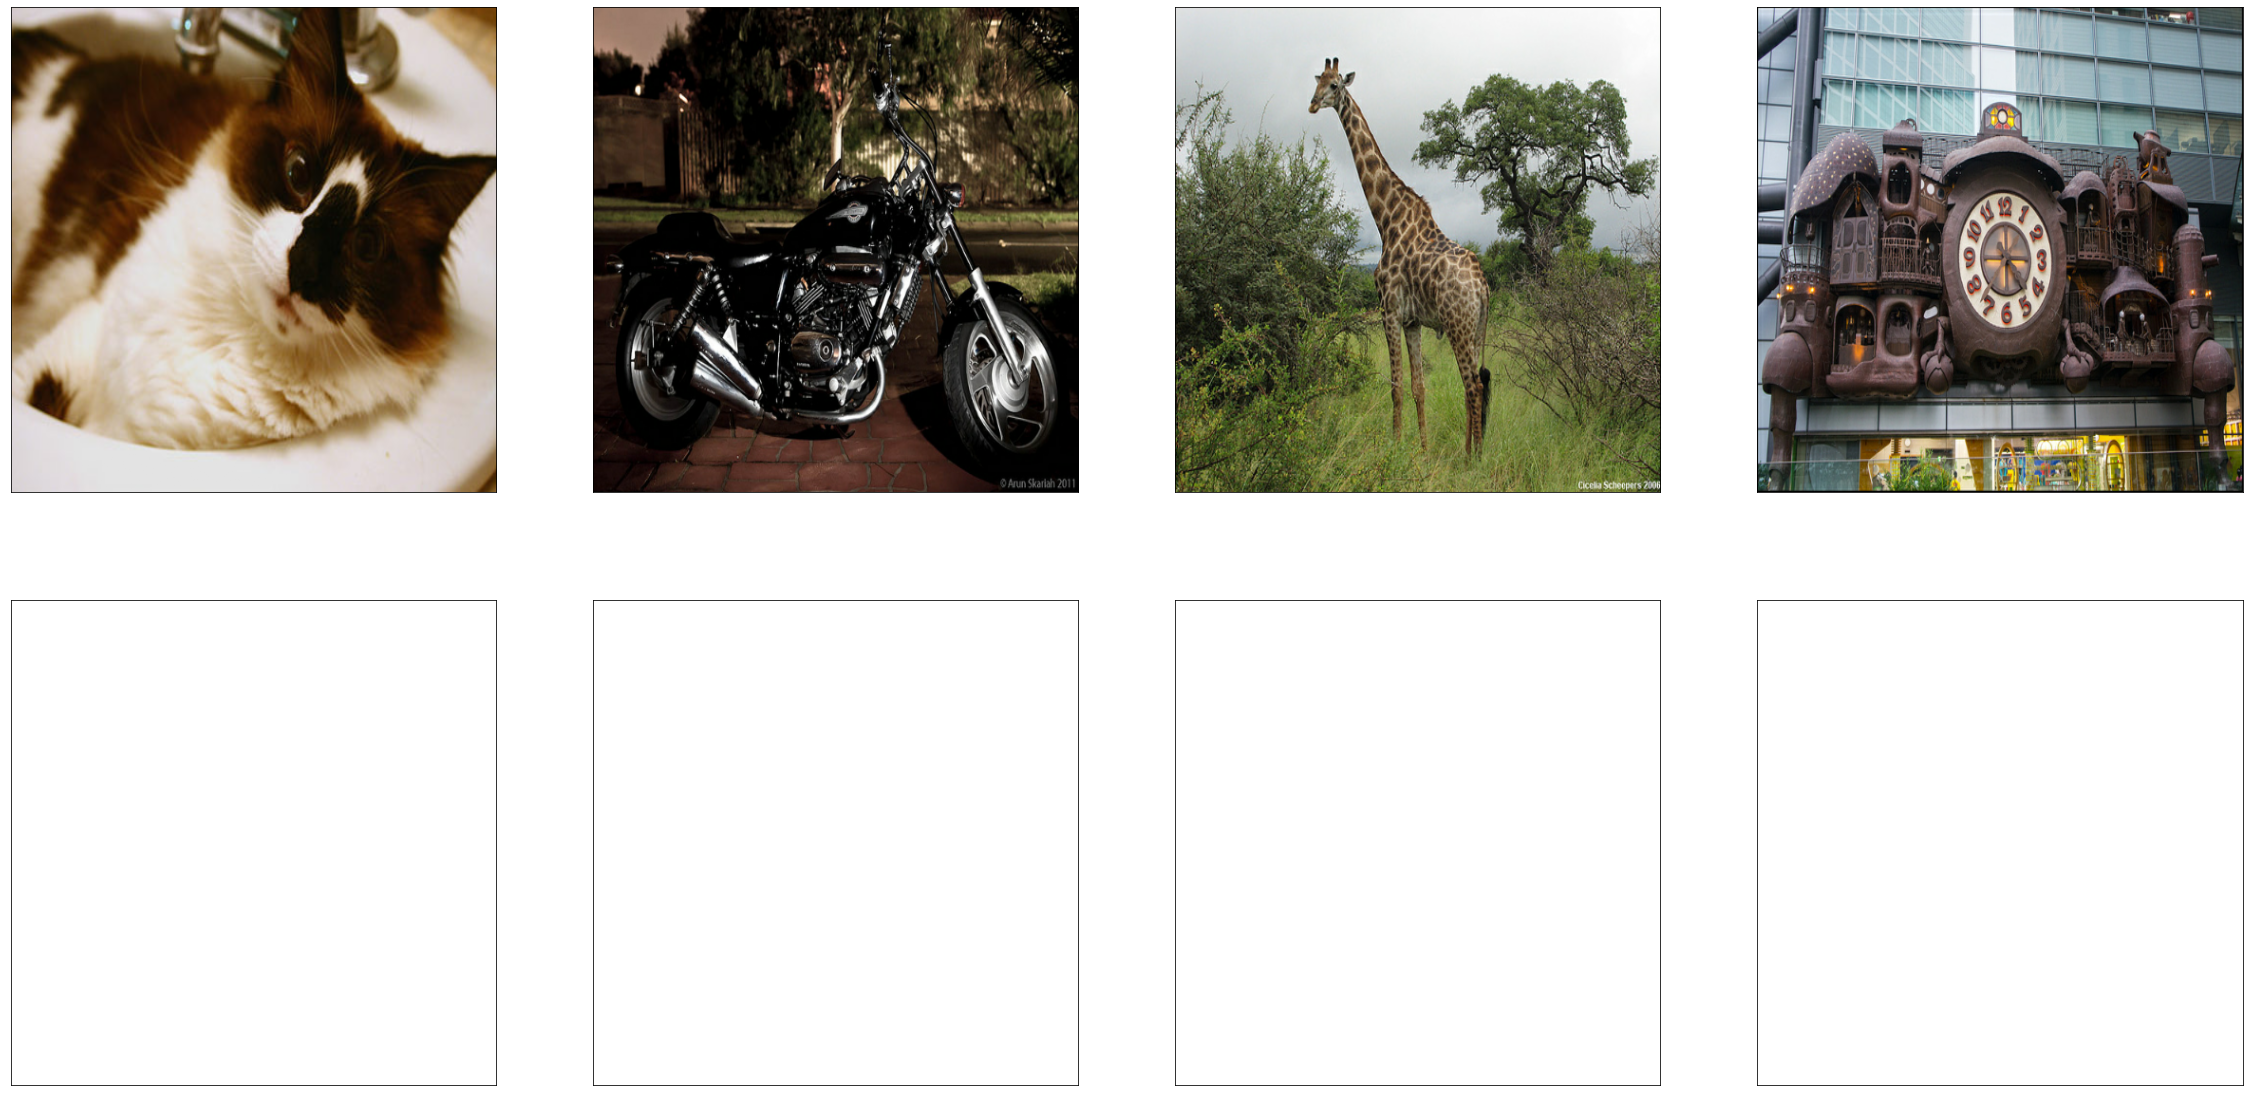

In [54]:
n=4
plt.figure(figsize=(40,20))
for i in range(1, n+1):
    ax = plt.subplot(2, n, i)
    plt.imshow(test_batch[i-1]/255)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2,n,i+n)
    plt.imshow(predicted[i-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Visualizing loss

In [35]:
autoencoder.save('saved_model/AEncoder')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/AEncoder/assets
